---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

{{< include overview.qmd >}} 

# Code 

Some of the text in these sections was informed by ChatGPT to help explain the code using prose to ensure someone not fluent in code could understand it. @gpt4o_prose_explain


In [31]:
# ------------------------------------ IMPORTS ------------------------------------ #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering 

df = pd.read_csv('../../data/processed-data/dc_bike_routes.csv')
df.head()

,name,distance_mi,terrain,traffic,scenery,distance_norm,unpaved,flat,workout,park,river,loop,sentiment,state1,state2
0,Potomac Tour,10,1,2,2,-0.963394,0,0,0,0,0,0,0.4215,DC,DC
1,BWI Trail,11,2,1,3,-0.933354,0,0,0,0,0,0,0.0000,MD,MD
2,Airpark Cruise,12,3,3,3,-0.903313,1,0,1,1,0,0,0.0000,MD,MD
3,Seneca Valley Tour,13,3,3,2,-0.873273,0,0,1,1,0,0,0.6249,MD,MD
4,For The Boyds,14,2,3,2,-0.843232,1,0,1,1,0,0,0.0000,MD,MD


## Part 1: Dimensionality Reduction

In this section we explore the effectiveness of dimensionality reducing techniques. 

### PCA
First we prepared the data by removing non-numeric columns, leaving only numerical features in `numeric_df`. The remaining data is then standardized with `StandardScaler` to ensure all features have a mean of 0 and a standard deviation of 1. This standardization is necessary because PCA can be sensitive to the scale of the data. PCA is applied to the scaled data without specifying the number of components, resulting in all possible components being computed. The `pca.fit_transform` method transforms the data into the new principal component space. The `explained_variance_ratio_` attribute of the PCA object provides the proportion of variance explained by each component. Then we visualize the cumulative sum of this explained variance against the number of PCA components to identify a "cutoff" point. The line is pretty constant but we believe 90% is a sufficient portion, so we conclude that 7 principal components is sufficient.

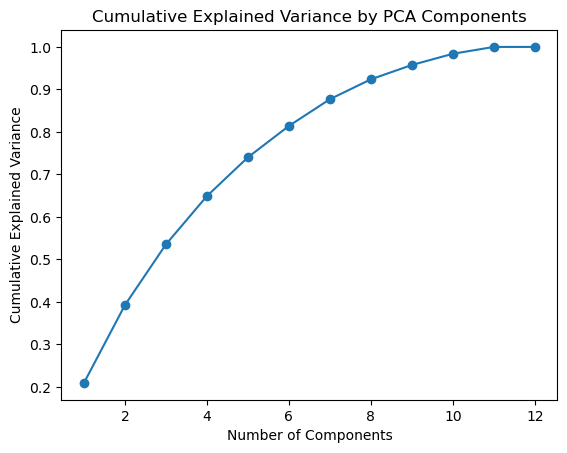

In [32]:
# Standardize the data (often helps with clustering)
numeric_df = df.drop(columns=['name','state1','state2'])
scaled_df = StandardScaler().fit_transform(numeric_df)

# Apply PCA
pca = PCA()
# apply pca to scaled data
pca_result = pca.fit_transform(scaled_df)

# plot explained variance
explained_variance_ratio = pca.explained_variance_ratio_
# plot number of components against cumulative explained variance
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o')
# label the plot
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Next, since we can't visualize what something is looks like in 7-dimensions, we will apply the first 2 components to visualize the data in two dimensions. We plot this 2D visualization, where The x-axis and y-axis correspond to the first and second principal components. Points are color-coded based on the `sentiment` column from the original dataset, allowing for the identification of patterns or clusters related to sentiment. This 2D visualization provides an intuitive way to observe structure and relationships in the data, such as clustering tendencies or separations between different sentiment values. 

The only trend that appears in sentiment is that lower sentiments appear lower across principal component 2 and increase with it. This could mean a couple of things:

1. The lack of distinct clusters might indicate that the variables in the dataset do not exhibit strong groupings or separations related to the target variable
2. PCA is a linear dimensionality reduction method, meaning it captures only linear relationships in the data. If the relationships between variables and sentiment are non-linear, PCA might not reveal meaningful clusters.
3. If the explained variance ratio of the first two components is relatively low, it suggests that the 2D representation does not capture much of the total variance in the data.

In our case the 3rd explanation makes the most sense as we saw in the previous graph how the variance is not explained very well until about 6 or 7 components. Let's check out the rank varibles.

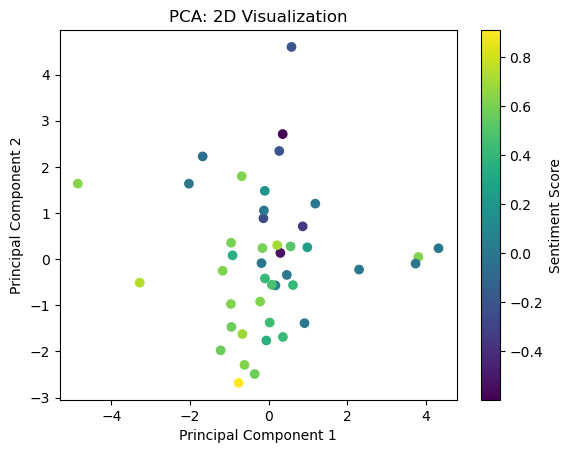

In [33]:
# Reduce dimensions to 2D
pca_2d = PCA(n_components=2)
# fit PCA to scaled data
pca_2d_result = pca_2d.fit_transform(scaled_df)

# plot resulting 2 d representation of data 
plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], c=df['sentiment'], cmap='viridis')
# label the plot
plt.title('PCA: 2D Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Sentiment Score')
plt.show()

Below we graph the principal components for all the variables that were ranked for the bike routes. We begin to see some clusters or trends in these plots. 

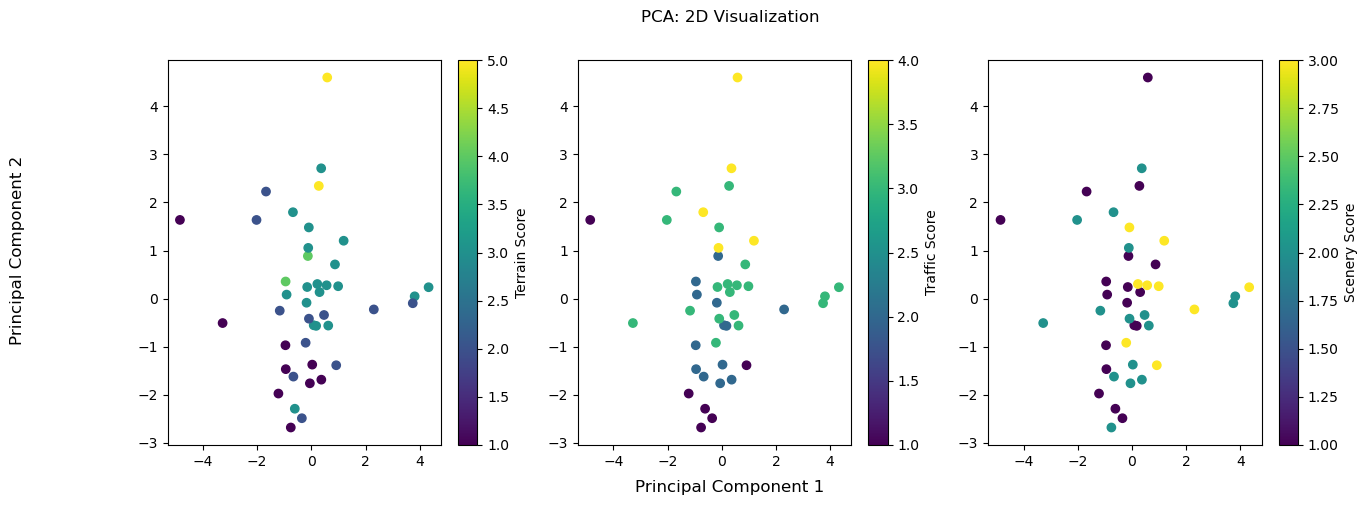

In [34]:
# define rank vars
rank_vars = ['terrain','traffic', 'scenery']
# make subplots to plot them next to eachother
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# loop through the axes and plot each
for i in range(len(axes)):
	im = axes[i].scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], c=df[rank_vars[i]], cmap='viridis')
	# add colorbar to each as they are all different
	fig.colorbar(im, label=f'{rank_vars[i].capitalize()} Score', ax=axes[i])
# label the plots
fig.suptitle('PCA: 2D Visualization')
fig.supxlabel('Principal Component 1')
fig.supylabel('Principal Component 2')    
plt.show()

### TSNE

This code applies t-Distributed Stochastic Neighbor Embedding (t-SNE), a non-linear dimensionality reduction technique, to visualize the dataset in two dimensions. Unlike PCA, which is linear, t-SNE is designed to preserve local structure in the data, making it particularly effective for revealing patterns such as clusters in datasets with complex relationships.

Since we have a relatively small dataset (only 43 observations), we will search across a smaller range of perplexity values since the value controls how many neighbors are used for each point. Here we iterate over the perplexity values of 5 to 30, computing the KL Divergence at each perplexity, and plot them against each other. Perplexities that yield lower KL divergence indicate that the t-SNE embedding is better at maintaining the data's structure. This helps determine an appropriate perplexity value for the dataset without relying solely on trial-and-error. We don't see any substantial improvements after 20, and adding more might distort as we near the total number of observations. 

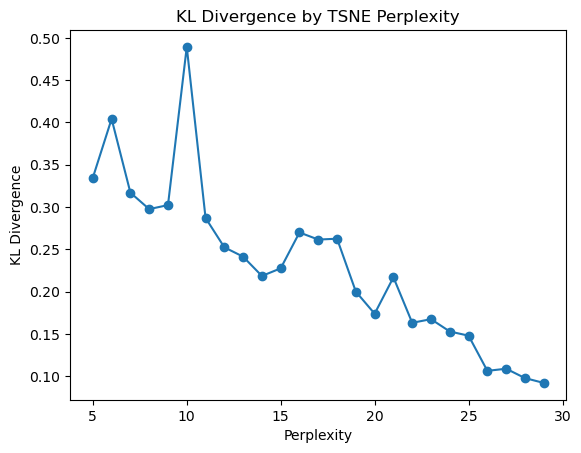

In [35]:
# initialize list to hold kl div vals and which perplexities we want to test
kl_vals = []
perps = range(5,30)
# iterate over the perplexities
for i in perps:
    # fit tsne with using current perplexity
    tsne = TSNE(perplexity=i, random_state=24).fit(scaled_df)
    # append kl divergence
    kl_vals.append(tsne.kl_divergence_)
# plot kl divergence against perplexity
plt.plot(perps, kl_vals, marker='o')
plt.title('KL Divergence by TSNE Perplexity')
plt.xlabel('Perplexity')
plt.ylabel('KL Divergence')
plt.show()

The process begins by initializing t-SNE with two dimensions (`n_components=2`) to reduce the data into a 2D space suitable for visualization. The `perplexity` parameter, set to 20, controls the balance between local and global structure in the embedding, while a fixed `random_state` ensures reproducibility of the results. The algorithm transforms the scaled features into a new coordinate system, capturing the intricate non-linear relationships that may not be evident in PCA's linear projections. The 2D results are plotted as a scatter plot, where each point corresponds to a data instance. The points are color-coded by the sentiment column to visually explore whether distinct groupings or gradients align with the sentiment values. We don't see any distinctive clustering in the data across the sentiment score. 

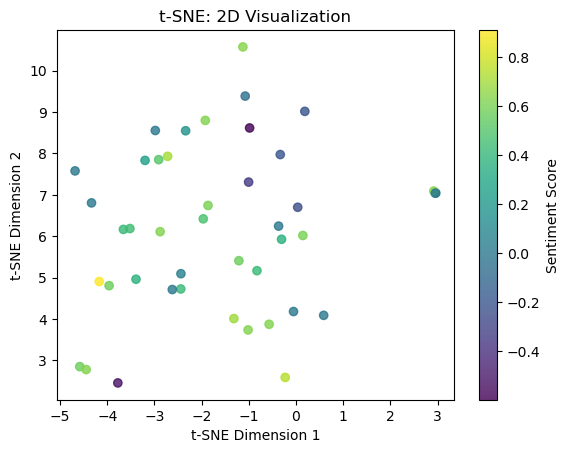

In [36]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=20, random_state=24)
tsne_result = tsne.fit_transform(scaled_df)
# Visualize t-SNE results
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['sentiment'], cmap='viridis', alpha=0.8)
plt.title('t-SNE: 2D Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Sentiment Score')
plt.show()

Similar to above with PCA. We plot the t-SNE again using the ranked variables to color the points. There still doesn't seem to be any obvious clustering, but there is some patterns seen. 

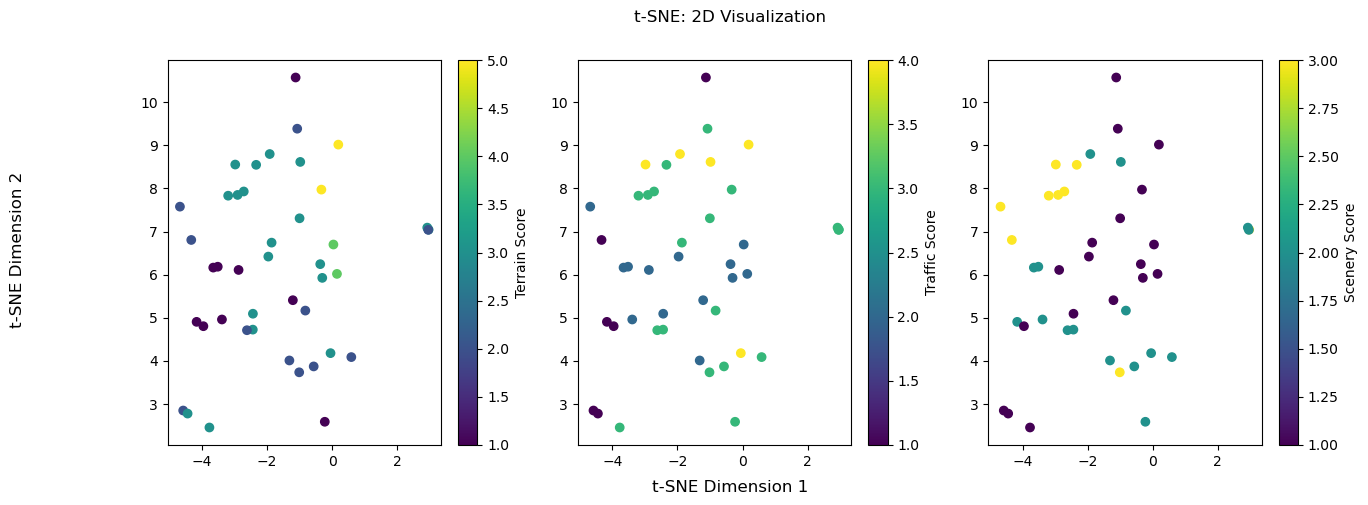

In [37]:
# make subplots to plot them next to eachother
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# loop through the axes and plot each
for i in range(len(axes)):
	im = axes[i].scatter(tsne_result[:, 0], tsne_result[:, 1], c=df[rank_vars[i]], cmap='viridis')
	# add colorbar to each as they are all different
	fig.colorbar(im, label=f'{rank_vars[i].capitalize()} Score', ax=axes[i])
# label the plots
fig.suptitle('t-SNE: 2D Visualization')
fig.supxlabel('t-SNE Dimension 1')
fig.supylabel('t-SNE Dimension 2')    
plt.show()

### Evaluation

Both PCA and t-SNE were applied to reduce the dataset's dimensionality for visualization, but neither method produced distinct, well-separated clusters. However, some patterns were observed, suggesting that the data does contain structure, although not strong enough for clear cluster separation in a 2D representation. This outcome highlights the need to carefully evaluate the strengths and limitations of each method when applied to high-dimensional data.

As a linear technique, PCA captures the directions of maximum variance in the data and projects it onto fewer dimensions. It excels at preserving global structure, making it effective for understanding overarching patterns or trends. However, it's reliance on linear projections means it may not reveal subtle, non-linear relationships. The cumulative explained variance plot provided insight into how much of the data’s variability is retained by the reduced components.

In contrast, t-SNE is designed to handle non-linear structures by preserving local similarities between data points. Its visualization often reveals small-scale patterns, such as clusters of similar instances, that might be missed by PCA. In this case, t-SNE revealed patterns that were not fully captured by PCA, but the lack of strong, distinct groupings suggests that either the data does not have well-defined clusters.

The following are some scenearios in which one method might be better than the other:
- PCA is ideal when the primary goal is dimensionality reduction for interpretability, feature analysis, or global trend visualization. It is computationally efficient and works well with linearly separable data.
- t-SNE is better suited for uncovering non-linear patterns and exploring local relationships, especially when clustering or separation is of interest in highly complex datasets. However, it is less effective for preserving global data structure and requires careful parameter tuning.

## Part 2: Clustering Methods

Next we will apply clustering techniques to the data to uncover any groupings that exist. 

### K-Means

K-Means is a widely-used clustering algorithm that partitions a dataset into a pre-defined number of clusters. It operates by initializing cluster centroids, assigning each data point to the nearest centroid, and iteratively updating the centroids based on the mean positions of points within each cluster. This process continues until the assignments stabilize, minimizing the within-cluster variance.

A key aspect of K-Means is determining the optimal number of clusters, often guided by methods such as the Elbow Method or Silhouette Score Analysis. The Elbow Method involves plotting the inertia, or the sum of squared distances of samples to their cluster, against the number of clusters and looking for a point where adding more clusters yields diminishing improvements. Silhouette score evaluates cluster quality by measuring how similar a point is to its own cluster compared to others. It compares the average distance between a data point and other points in its cluster to the average distance to points in other clusters. While K-Means is computationally efficient and effective for well-separated clusters, it assumes spherical cluster shapes and may perform poorly with non-spherical distributions or data with significant outliers.

Below, we perform both methods to select an optimal number of clusters. First, we loop over the different values for the number of clusters and store their inertia and silhouette scores. We then plot these against the number of clusters to find a point that is diminishing returns for the elbow method, or the best score for silhouette score. We see somewhat of a drop-off at 8 or 9 for the elbow  silhouette score so we cross check with the elbow method. While the inertia continues to decrease, it displays diminishing returns at this point. 

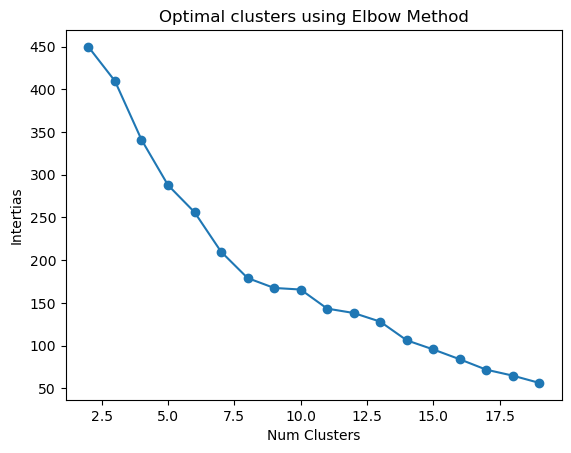

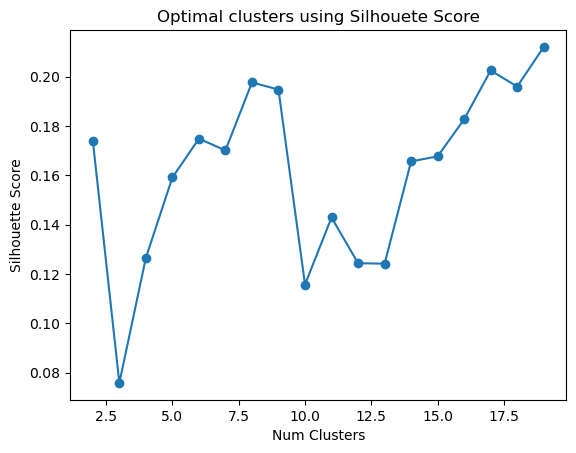

In [38]:
# initialize the k vals to test, and lists to store scores
k_vals = range(2,20)
sil_scores = []
inertias = []
# iterate over k vals
for k in k_vals:
	# fit the model to our data using current k
	kmeans_model = KMeans(n_clusters=k, random_state=24).fit(scaled_df)
	# append inertia to list
	inertias.append(kmeans_model.inertia_)
	# Extract score and append to list. Appene current k
	score = silhouette_score(scaled_df, kmeans_model.labels_)
	sil_scores.append(score)

# plot elbow method
plt.figure()
plt.plot(k_vals, inertias, "-o")
plt.title("Optimal clusters using Elbow Method")
plt.ylabel("Intertias")
plt.xlabel("Num Clusters")
plt.show()
# plot silouette score 
plt.figure()
plt.plot(k_vals, sil_scores, '-o')
plt.title("Optimal clusters using Silhouete Score")
plt.ylabel("Silhouette Score")
plt.xlabel("Num Clusters")
plt.show()


Here, the K-Means algorithm is applied with 8 clusters and each data point is assigned to one of these clusters, the resulting labels added to the DataFrame under the column `kmeans_cluster`. For visualization, the code uses the t-SNE result to map the high-dimensional data into two dimensions, where points are plotted and color-coded by their assigned K-Means cluster. The scatter plot illustrates how the clusters identified by K-Means are distributed in the 2 dimensional space. 

The graph reveals reasonably well-defined clusters, indicating that the K-Means algorithm has effectively grouped similar data points. However, the clusters are unbalanced, with some containing very few points while others are relatively large. This imbalance could be explained by inherent characteristics of the dataset, such as a naturally skewed distribution of data or an uneven density of points across the feature space. The imbalance in cluster sizes highlights a potential limitation of K-Means in this context. While the algorithm minimizes variance within clusters, it assumes clusters of similar sizes and may assign small groups to their own clusters if their variance significantly differs from larger groups. 

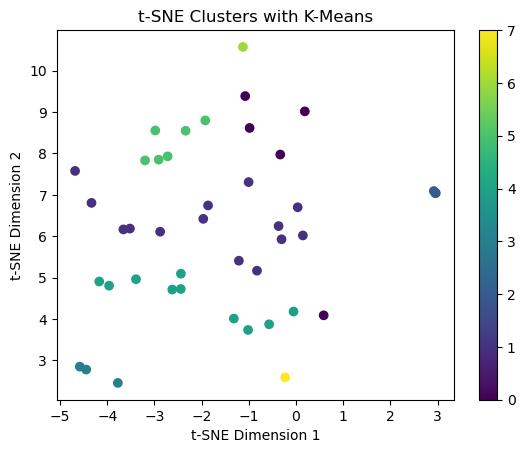

In [39]:
# Optimal Clusters
optimal_kmeans = KMeans(n_clusters=8, random_state=24)
df['kmeans_cluster'] = optimal_kmeans.fit_predict(scaled_df)

# plot points in tsne space, colored on kmeans cluster
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['kmeans_cluster'])
plt.title('t-SNE Clusters with K-Means')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

### DBSCAN 

DBSCAN, which stands for Density-Based Spatial Clustering of Applications with Noise, is a non-parametric clustering algorithm that identifies clusters based on data density. It groups points that are densely packed together while marking points in low-density regions as noise. The most important hyper-parameters for DBSCAN are `eps` (maximum distance for points to be considered neighbors) and `min_samples` (minimum number of points required to form a dense region). 

Unlike K-Means, DBSCAN does not require specifying the number of clusters in advance, making it particularly useful for datasets with irregular cluster shapes or varying densities. However, parameter selection is crucial. Techniques like examining the k-distance plot can help identify an appropriate eps value by finding a knee point, where the distance increases sharply. DBSCAN is robust to noise and handles non-spherical clusters well, but it may struggle with high-dimensional data where density estimation becomes challenging or when eps is not appropriately tuned for the dataset’s scale.

The code below steps through identifying the optimal parameters for DBSCAN. This 2D grid search covers ranges for both `eps` and `min_sample` calculates the silhouette score at every combination of the two parameters, updating the best score and parameter values if better than what has been seen before. Since we are dealing with data that is fairly spread out in the vector space, we look at higher values of `eps` than is traditionally used. Also, note that in order to calculate silhouette score, the number of clusters needs to be at least 2 and less than the number of observations in the data. After iterating through all possible combinations, the code prints the best silhouette score, along with the corresponding `eps` and `min_samples` values. 

This approach serves to automate the parameter tuning process for DBSCAN, which can be challenging since the algorithm's performance is highly sensitive to eps and min_samples. By evaluating all combinations within the specified ranges and using the silhouette score as a measure of quality, this method ensures that the best-performing parameters are selected.

In [40]:
# intialize values
best_eps = None
best_min_sample = None
best_score = -1
# iterate through values for both eps values and min_sample
for eps in np.arange(.1,4,.1):
	for min_sample in range(1,10):
		# make dbscan model with current parameters
		dbscan_model = DBSCAN(eps=eps, min_samples=min_sample).fit(scaled_df)
		# if labels fit within requirements, calculate silhouette score
		if 1 < len(set(dbscan_model.labels_)) < len(scaled_df):
			score = silhouette_score(scaled_df, dbscan_model.labels_)
			# if current score is better than our best, reset parameters
			if score > best_score:
				best_score = score
				best_eps, best_min_sample = eps, min_sample

# Ouput results
print("Best Score:", best_score, "\nBest Epsilon:", best_eps, "\nBest min sample: ", best_min_sample)

Best Score: 0.3176437786872938 
Best Epsilon: 3.4000000000000004 
Best min sample:  3


Here the DBSCAN algorithm is applied with the optimal parameters to our dataset and the predicted clusters are added to the data frame. Next, the scatter plot maps the cluster assignments onto the 2D t-SNE space of the data. Each point is color-coded according to its dbscan_cluster label, with a color bar to distinguish different clusters.

Several points are labeled as -1, representing noise. This indicates that these points were in low-density areas or isolated regions of the dataset, which DBSCAN appropriately excludes from clusters. While this can reflect meaningful patterns, such as outliers or transitional areas between clusters, it may also suggest that some relevant data points are being excluded as in our case of attempting to cluster bike routes. We also notice that the clusters uneven in size, with one containing all but three of the data points. This imbalance often occurs with DBSCAN, as the algorithm naturally groups points into clusters based on density rather than trying to create clusters of equal size. Overall, the clusters aren't very informative, highlighting the challenges of interpreting imbalanced clusters and noise in the context of the dataset.

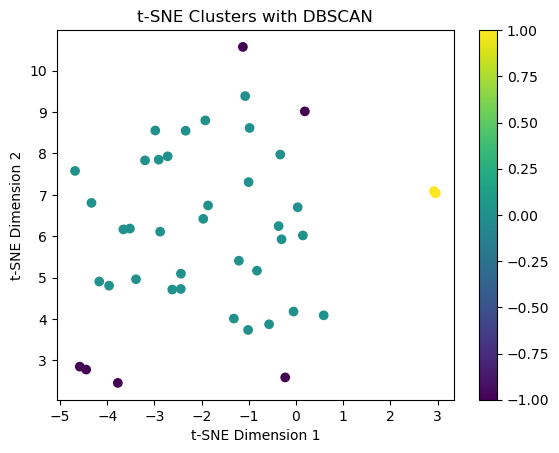

In [41]:
# fit dbscan with optimal params and add column to df
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_sample)
df['dbscan_cluster'] = dbscan.fit_predict(scaled_df)
# plot the clusters
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['dbscan_cluster'], label=df['dbscan_cluster'])
plt.title('t-SNE Clusters with DBSCAN')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

### Hierarchical Clustering 

Hierarchical clustering builds a tree-like structure to represent the relationships between data points. It comes in two forms: agglomerative (bottom-up) and divisive (top-down). Agglomerative clustering, the more common approach, starts with each data point as its own cluster and merges the closest clusters iteratively until a single cluster is formed. This is the approach we will use in our analysis. 

There are several important hyper-parameters with agglomerative clustering, such as, choice of linkage criteria, choice of distance metric, and number of clusters. However, in our analysis we will just focus on `n_clusters` as the other two are more complex and reach beyond the scope of our analysis. Hierarchical clustering is effective for small to medium-sized datasets where relationships between points are more intuitive. However, it can be computationally expensive for large datasets and may suffer from sensitivity to noise and outliers.

This code below is designed to evaluate the performance of the Agglomerative Clustering algorithm across a range of potential cluster counts using the Silhouette Score. The goal is to identify the optimal number of clusters by analyzing how well-separated the clusters are in terms of their cohesion (internal) and separation (external). We iterate over a range of clusters, knowing we need at least 2 and picking a value lower than our total observations. For each number of clusters, we create an instance of the `AgglomerativeClustering` model with the current number of clusters, fit the model to the scaled dataset, and calculate the silhouette score. Then plot these scores against the number of clusters. We see a stark drop after 3 clusters and then a slow build to a local maximum at 18. While 3 clusters produces a better result, the behavior around the point is less predictable. 

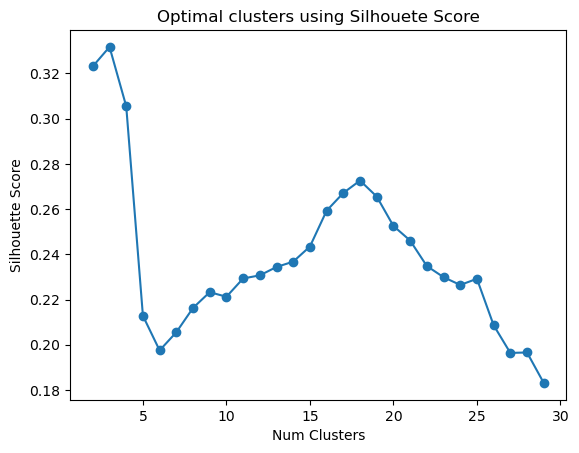

In [42]:
# initialize to hold info
n_vals  = range(2,30)
sil_scores = []
# loop through n values, need at least 2 clusters for silhouette
for n in n_vals:
    # fit the model to our data using current n
    cluster_model = AgglomerativeClustering(n_clusters=n).fit(scaled_df)
    # get score and add to list
    score = silhouette_score(scaled_df, cluster_model.labels_)
    sil_scores.append(score)
    
# plot the scores against clusts
plt.plot(n_vals, sil_scores, '-o')
plt.title("Optimal clusters using Silhouete Score")
plt.ylabel("Silhouette Score")
plt.xlabel("Num Clusters")
plt.show()

As explained above, the behavior near 3 clusters is less predictable, so here we apply the clustering using the other maximum of 18 clusters. Similar as what was done with K-Means and DBSCAN, we plot the data in the 2D t-SNE space color based on the predicted cluster assignments. 

The clusters appear reasonably well-separated, with distinct groups of points that reflect the underlying structure of the data. This suggests that Agglomerative Clustering has identified meaningful patterns or groupings within the dataset. However, the presence of a relatively large number of clusters, could indicate that the clustering algorithm has over-partitioned the data. The high number of clusters could also be indicative of the algorithm’s sensitivity to the distance metric and the scale of the data. As seen in the second plot, where we try 3 clusters, the outcome is even less informative. 

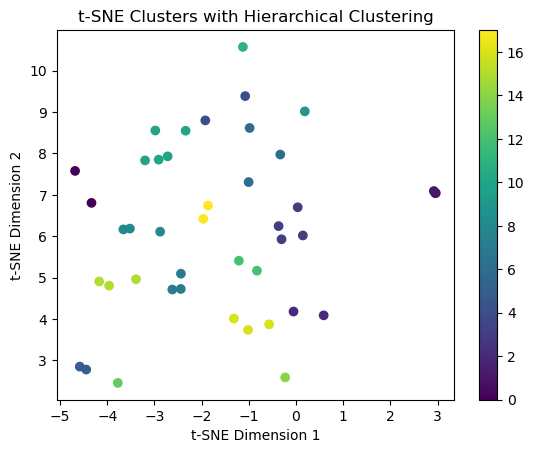

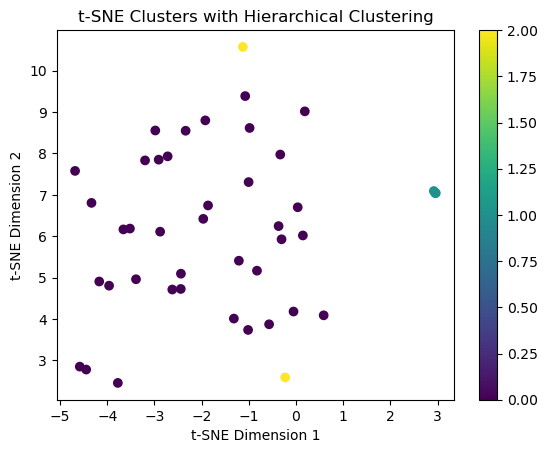

In [43]:
# fit model using 2 clusters
agg_cluster = AgglomerativeClustering(n_clusters=18)
# add predictions back to df
df['agg_cluster'] = agg_cluster.fit_predict(scaled_df)

# plot points colored on agglomerative cluster
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['agg_cluster'])
plt.title('t-SNE Clusters with Hierarchical Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

# plot again using only 2 clusters
cluster3 = AgglomerativeClustering(n_clusters=3).fit_predict(scaled_df)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster3)
plt.title('t-SNE Clusters with Hierarchical Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

### Results

In this analysis, three clustering algorithms—K-Means, DBSCAN, and Agglomerative Clustering—were applied to the dataset of bike routes in Washington, DC, with the goal of identifying natural groupings of the routes based on their features, such as distance, ratings, descriptions, and sentiment

K-Means clustering provided a reasonable grouping of bike routes into 10 clusters, as determined by evaluating different cluster counts and selecting the optimal number based on silhouette scores. The resulting clusters appeared somewhat balanced in terms of size, though there were a few smaller clusters containing fewer routes. The clusters formed by K-Means generally aligned with routes that shared common features, such as similar distances or ratings.

DBSCAN was effective at identifying clusters of varying shapes and sizes. The algorithm’s ability to classify some data points as noise (assigned the label -1) highlighted routes that did not fit well into any of the primary clusters. While DBSCAN’s ability to identify noise is beneficial for excluding irrelevant data, it resulted in an uneven distribution of clusters. Many of the clusters formed were relatively small, and several routes were classified as noise. This imbalance points to the algorithm’s sensitivity to the density of points, and it suggests that DBSCAN may be more suited for datasets that aren't as empty in the vector space as ours. 

Agglomerative Clustering with 17 clusters produced the most granular results, splitting the bike routes into small and imbalanced clusters. This high number of clusters indicated that the algorithm over-partitioned the data, potentially identifying small, subtle groupings that might not have significant practical meaning. The large number of clusters posed a challenge for interpreting the results, as the small clusters could represent noise or slight variations in the routes, which may not be as valuable for decision-making.

# Conclusions

From a practical perspective, K-Means is the most useful clustering technique for categorizing bike routes in a way that helps urban planners or biking enthusiasts make decisions about route accessibility, popularity, and preferences. Understanding how routes cluster based on distance, rating, or sentiment could inform route improvements or the development of new bike paths. DBSCAN’s identification of noise could also help filter out anomalous routes that might require further investigation, while Agglomerative Clustering’s fine-grained results could be useful for very specific analyses, though it may be best suited for exploratory rather than practical purposes. Overall, these clustering techniques provide valuable tools for gaining insights into the bike route data, with K-Means emerging as the most actionable method for most real-world applications.

